In [1]:
import numpy as np
import sys
import nest_asyncio
import math 
from pyquaternion import Quaternion
from geopy import distance
from math import cos
from math import sin
from math import asin
from math import atan2
from haversine import Unit
from pyproj import Proj
import pyproj
from math import cos, radians
from scipy.spatial.transform import Rotation

#import rasterio
import random
from natsort import natsorted,realsorted, ns
from tqdm.notebook import trange, tqdm
from time import sleep
import osmnx as ox
import haversine as hs
import shutil
from numpy import asarray
from IPython import display
import os
from os import listdir
import utm
import geopandas
from pathlib import Path
import glob
import concurrent.futures
import geotiler
import cv2 
import matplotlib.pyplot as plt
import h5py
import imutils
import mplleaflet
from PIL import Image, ImageDraw
%matplotlib inline

In [2]:
Logname = 'AtCityBMW_Applanix-20220601T115459Z469'
path = 'C:/Users/bjqb7h/Downloads/Thesis2022/GPS DATA/'
path_position = 'sensors/ApplanixDGPS'
path_orientation = 'sensors/ApplanixDGPS/orientation'
path_timestamps = 'sensors/ApplanixDGPS/timestamps'
path_meta = 'C:/Users/bjqb7h/Downloads/Thesis2022/Meta'

hDF5_PATH = 'C:/Users/bjqb7h/Downloads/Thesis2022/NUMPY/New'
dir0 = r'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_1/Dataset/RadarGPS'
dir1 = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Rotate/GPSRADAR/RotatedMAPS'
dir2 = 'C:/Users/bjqb7h/Downloads/Thesis2022/HD Maps_Cropped/GPSRADAR'


In [3]:
#Read Hdf5 filel for the Radar data and GPS data.
hf1 = h5py.File(path+Logname+'.h5','r')
dset = hf1[path_position]['position']
dset1= hf1[path_orientation]
dsetA = hf1.get(path_timestamps)
GPSTimestamp=np.array(dsetA)


In [4]:
#Extract all the Latitudes,Longitude and Orientation(Quaternions) 
Long=dset[:,0] #Longitude
Lat=dset[:,1]  #Latitude
Alt = dset[:,2] #altitude
q0=dset1[:,0]  #Quaternions 1
q1=dset1[:,1]  #Quaternions 2
q2=dset1[:,2]  ##Quaternions 3
q3=dset1[:,3] ##Quaternions 4

size= len(Long) #Size of the dataset ususally len(long)

nest_asyncio.apply()


In [5]:
#Initializing the values of the lever arms and IMU
GNSS_lever_arm = np.array([-0.335, -0.424, -1.082])
IMU_lever_arm = np.array([-0.181, -0.001, -0.206])
IMU_angles = np.array([-0.201, 0.100, -0.229])
ref_to_veh_angles = np.array([0, 0, 0])
x_transformed =np.zeros((len(Long),1),dtype =np.float64)
y_transformed =np.zeros((len(Long),1),dtype =np.float64)

In [6]:
def quat_to_rotmat(q0, q1, q2, q3):
    #Converts quaternions q0, q1, q2, and q3 to a rotation matrix.
    
    R = np.zeros((3, 3))
    R[0, 0] = 1 - 2*q2**2 - 2*q3**2
    R[0, 1] = 2*q1*q2 - 2*q0*q3
    R[0, 2] = 2*q0*q2 + 2*q1*q3
    R[1, 0] = 2*q1*q2 + 2*q0*q3
    R[1, 1] = 1 - 2*q1**2 - 2*q3**2
    R[1, 2] = 2*q2*q3 - 2*q0*q1
    R[2, 0] = 2*q1*q3 - 2*q0*q2
    R[2, 1] = 2*q0*q1 + 2*q2*q3
    R[2, 2] = 1 - 2*q1**2 - 2*q2**2
    return R

def GPS_data_Transformation(Long,Lat,q0,q1,q2,q3):
    RotationM =np.zeros((len(Long),3,3),dtype =np.float64)

    H =np.zeros((len(Long),4,4),dtype =np.float64)
    
    for i in range(0,len(q0)):
        RotationM[i,:,:] = quat_to_rotmat(q0[i], q1[i], q2[i], q3[i])
    #Generating the transformation matrix H which contain parameters 
    #to transform the GPS coordinates from the antenna coordinate system to the vehicle coordinate system.
   
    utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
    x, y = utm_proj(Long, Lat) #Converting the local coordinate system to world coordinate system
  
    for i in range(len(Long)):
        H[i,:,:] = np.eye(4)
        H[i,:3, :3] = RotationM[i,:,:]
        t = np.array([x[i], y[i], 0]) # GPS Longitude . latitude in x ,y,z
        H[i,:3, 3] = t.flatten()

    return H



When we created the H transformation matrix and used it with the test matrix T, we changed the coordinates from the antenna coordinate system to the vehicle coordinate system. The H matrix contains the rotation and translation parameters to transform the GPS coordinates from the antenna coordinate system to the vehicle coordinate system, while the test matrix T contains the rotation and translation parameters of the antenna coordinate system relative to the vehicle coordinate system. Multiplying H with T results in a new matrix, NewH, which is the transformation matrix for transforming GPS coordinates from the antenna coordinate system to the vehicle coordinate system. Therefore, the transformation process involves changing the coordinates from the antenna coordinate system to the vehicle coordinate system.

In [7]:
def Verification_calibration(Long,Lat,q0,q1,q2,q3):
    
    #Reference points F1 and F2 and F3
    F1=[0,0,0,1]
    F2=[1,0,0,1]
    F3=[0,1,0,1]


    NewH=np.zeros((len(Long),4,4),dtype =np.float64)
    NewF5=np.zeros((len(Long),4),dtype =np.float64)

    T=np.eye(4)# # Creating a 4*4 matrix

    R1=Rotation.from_euler("zx",[201,180],degrees=True).as_matrix() #
    #Rotation and translation parameters of the antenna coordinate system relative to the vehicle coordinate system

    T[:3,:3]=R1 #moving the rotation parameters R1 to test matrix T
    T1=T.copy() #Creating a copy to show the transformation without translations added
    T[:3,3] = -np.matmul(R1,np.array([-0.335,-0.424, -1.082]))#Adding translations to the test matrix T
    
    H = GPS_data_Transformation(Long,Lat,q0,q1,q2,q3)

    for i in range(0,len(Long)):
        NewH[i,:,:]= np.matmul(H[i, :, :], T)#with translations
        NewH1 = np.matmul(H[i, :, :], T1)#to show without translations 
        NewF1 = np.matmul(NewH[i,:,:], F1)
        NewF2 = np.matmul(NewH[i,:,:], F2)
        NewF3 = np.matmul(NewH[i,:,:], F3)
        NewF4= np.matmul(NewH1, F1)
        NewF5[i,:]=np.matmul(NewH[i,:,:], F4)


        plt.plot([NewF1[0], NewF2[0]], [NewF1[1], NewF2[1]], 'b-')
        plt.plot([NewF1[0], NewF3[0]], [NewF1[1], NewF3[1]], 'r-')
        plt.plot(NewF4[0], NewF4[1], 'g.')

    plt.axis('equal')
    return plt.show()



In [9]:
def GenerateCalibrated_data(Long,Lat,q0,q1,q2,q3):
    F4=[1,1,1,1]
    NewH1=np.zeros((len(Long),4,4),dtype =np.float64)
    NewF5=np.zeros((len(Long),4),dtype =np.float64)

    T=np.eye(4)# # Creating a 4*4 matrix

    R1=Rotation.from_euler("zx",[201,180],degrees=True).as_matrix() #
    #Rotation and translation parameters of the antenna coordinate system relative to the vehicle coordinate system

    T[:3,:3]=R1 #moving the rotation parameters R1 to test matrix T
    T1=T.copy() #Creating a copy to show the transformation without translations added
    T[:3,3] = -np.matmul(R1,np.array([-0.335,-0.424, -1.082]))#Adding translations to the test matrix T
    
    H1 = GPS_data_Transformation(Long,Lat,q0,q1,q2,q3)

    for i in range(0,len(Long)):
        NewH1[i,:,:]= np.matmul(H1[i, :, :], T)#with translations
        NewF5[i,:]=np.matmul(NewH1[i,:,:], F4)
        
    
    utm_proj = Proj(proj='utm', zone=32, ellps='WGS84')
    longitude, latitude = utm_proj(NewF5[:,0], NewF5[:,1], inverse=True)
    
    
    return longitude, latitude



In [10]:
a,x=GenerateCalibrated_data(Long,Lat,q0,q1,q2,q3)

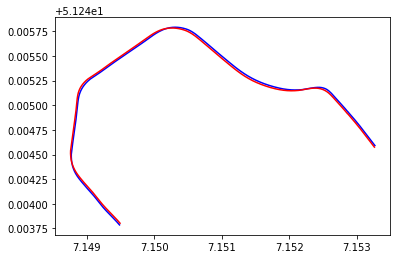

In [11]:

plt.plot(a,x,'b-')
plt.plot(Long,Lat,'r-')
# mplleaflet.display()

In [139]:
#Convert the GPS longitude and latitude points to a text file with a delimeter.

In [140]:
# x_transformed=longitude.ravel()
# y_transformed=latitude.ravel()
# delimiter = "," # Set the delimiter as a comma

# filename = "C:/Users/bjqb7h/Downloads/Thesis2022/gps_data11.txt" # Set the full path of the file

# with open(filename, "w") as f:
#     for i in range(len(Lat)):
#         f.write(str(x_transformed[i]) + delimiter + str(y_transformed[i]) + "\n")